<a href="https://colab.research.google.com/github/FelicianoRobles/FisicaComputacional1/blob/master/Actividad6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parte1
Tomar una serie de datos en un periodo sin huecos (Tmax, Tmin) de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una. Ver el ejemplo mostrado en la Jupyter Notebook de esta actividad para realizar las acciones similares. 

## Dataframe de referencia

In [193]:
# Bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Quitar alertas
%matplotlib inline

url = 'https://raw.githubusercontent.com/FelicianoRobles/FisicaComputacional1/master/Actividad3/3005.txt' # URL de inf raw  
my_cols = ['Fecha', 'Precip(MM)', 'Evap(MM)', 'Tmax(°C)', 'Tmin(°C)'] # Nombre a columnas
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python') # Leer

df_w1 = df_dist.copy() # Se hace una copia del dataframe

str_Nulo = 'Nulo'
df_w2 = df_w1.replace(to_replace=str_Nulo, value='', regex=True) # Reemplazar Nulo por un espacio en blanco

cols_list = ['Precip(MM)', 'Evap(MM)', 'Tmax(°C)', 'Tmin(°C)']
for cols in cols_list:
  df_w2[cols] = pd.to_numeric(df_w2[cols], errors='coerce') # Se convierten a números flotantes 
df_w2.isnull().sum()
# Un análisis estadístico breve de las variables numéricas redondeado a 2 cifras significativas
df_w2.describe().round(2)
df_w3 = df_w2.copy() # Se hace una copia del dataframe
df_w3['Fecha']=pd.to_datetime(df_w3['Fecha'], dayfirst=True).copy() # Primer dato que sea dia
df_w3['Año'] = df_w3['Fecha'].dt.year # Columna de año
df_w3['Mes'] = df_w3['Fecha'].dt.month # Columna de mes
#df_w3.dtypes # Verificar tipos

df_w6 = df_w3.copy() # Archico con que trabajar actividad 6
df_w6 = df_w6.set_index('Fecha') # El indice ahora es la fecha
df_w6.info()
print(df_w6.head())
print(df_w6.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25851 entries, 1937-06-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Precip(MM)  25828 non-null  float64
 1   Evap(MM)    6113 non-null   float64
 2   Tmax(°C)    24972 non-null  float64
 3   Tmin(°C)    24963 non-null  float64
 4   Año         25851 non-null  int64  
 5   Mes         25851 non-null  int64  
dtypes: float64(4), int64(2)
memory usage: 1.4 MB
            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(°C)   Año  Mes
Fecha                                                          
1937-06-01         0.0       NaN      33.0      11.0  1937    6
1937-06-02         0.0       NaN      33.0      11.0  1937    6
1937-06-03         0.0       NaN      33.0      11.0  1937    6
1937-06-04         0.0       NaN      32.0      11.0  1937    6
1937-06-05         0.0       NaN      33.0      12.0  1937    6
            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(

## Función para probar la estacionaridad de una serie de tiempo: 'timeseries'

In [194]:
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

## Dataframes a estudiar

In [195]:
start, end = '2001-01', '2015-10'
start2, end = '2001-11', '2015-10'

ts_w7 = df_w6.loc[start:end].copy()
ts_w8 = df_w6.loc[start2:end].copy()

print(ts_w7.head(2),'\n')
print(ts_w7.tail(2),'\n')
print(ts_w8.head(2),'\n') 
print(ts_w8.tail(2),'\n')

ts_testM = ts_w7['Tmax(°C)'].copy() # Temperatura Maxima
ts_testm = ts_w8['Tmin(°C)'].copy() # Temperatura Minima

            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(°C)   Año  Mes
Fecha                                                          
2001-01-01         0.0       3.2      29.0      15.0  2001    1
2001-01-02         0.0       2.8      28.0      14.5  2001    1 

            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(°C)   Año  Mes
Fecha                                                          
2015-10-15         0.0       NaN      37.0      26.0  2015   10
2015-10-16         0.0       NaN      36.0      25.0  2015   10 

            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(°C)   Año  Mes
Fecha                                                          
2001-11-01         0.0       NaN      34.0      22.0  2001   11
2001-11-02         0.0       NaN      35.0      21.0  2001   11 

            Precip(MM)  Evap(MM)  Tmax(°C)  Tmin(°C)   Año  Mes
Fecha                                                          
2015-10-15         0.0       NaN      37.0      26.0  2015   10
2015-10-16         0.0       NaN  

### Prueba de Tmax


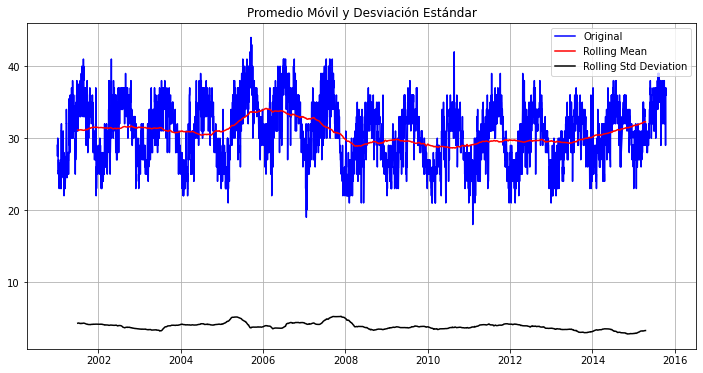

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.886390
p-value                           0.000037
#Lags Used                       24.000000
Number of Observations Used    5357.000000
Critical Value (1%)              -3.431571
Critical Value (5%)              -2.862080
Critical Value (10%)             -2.567057
dtype: float64


In [196]:
test_stationarity(ts_testM)
ts_max=ts_testM # Nuevo con nombre mas facil

### Prueba de Tmin

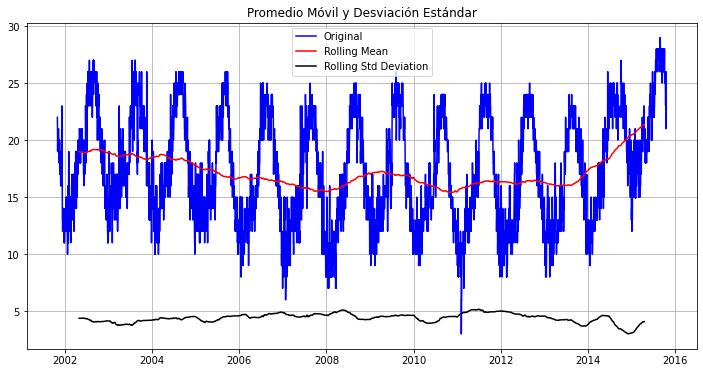

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -4.488210
p-value                           0.000207
#Lags Used                       33.000000
Number of Observations Used    5048.000000
Critical Value (1%)              -3.431646
Critical Value (5%)              -2.862113
Critical Value (10%)             -2.567075
dtype: float64


In [197]:
test_stationarity(ts_testm)
ts_min=ts_testm # Nuevo con nombre mas facil

# Parte 2
Construye los modelos ARIMA para cada Temperatura (Tmax y Tmin), y contrasta la bondad del ajuste en cada caso, calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo gráficamente ambas series, la observada y la construida con el método ARIMA.

## Tmax

### Preparacion

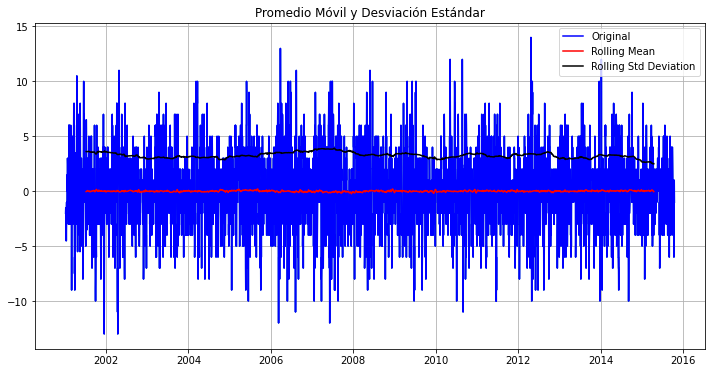

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.545071e+01
p-value                        2.786594e-28
#Lags Used                     3.300000e+01
Number of Observations Used    5.341000e+03
Critical Value (1%)           -3.431575e+00
Critical Value (5%)           -2.862081e+00
Critical Value (10%)          -2.567058e+00
dtype: float64


5375

In [183]:
# Diferenciamos usando la función df.shift()
ts_max_diff = ts_max - ts_max.shift(periods=7)
plt.plot(ts_max_diff);
# Diferenciamos usando la función df.shift()
# Probamos la estacionaridad
ts_max_diff.dropna(inplace=True)
test_stationarity(ts_max_diff)
len(ts_max_diff)

### Metodo ARIMA

#### Paso1

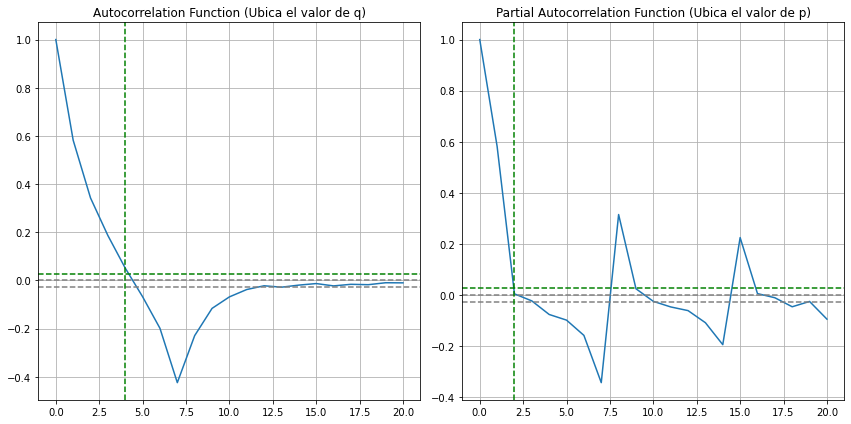

In [184]:
# Aplicamos ARIMA
lag_acf = acf(ts_max_diff, nlags=20)
lag_pacf = pacf(ts_max_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6) # Tamaño de las gráficas

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_max_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_max_diff)), linestyle='--', color='green')
# Líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_max_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_max_diff)), linestyle='--', color='green')

#Líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

#### Paso2 (Modelo AR (Auto-Regresión))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmax(°C)   No. Observations:                 5381
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -11407.421
Method:                       css-mle   S.D. of innovations              2.016
Date:                Fri, 19 Feb 2021   AIC                          22822.841
Time:                        23:53:26   BIC                          22849.204
Sample:                             1   HQIC                         22832.046
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0014      0.019      0.072      0.942      -0.037       0.039
ar.L1.D.Tmax(°C)    -0.2584      0.013    -19.208      0.000      -0.285      -0.232
ar.L2.D.Tmax(°C)    -0.1618 

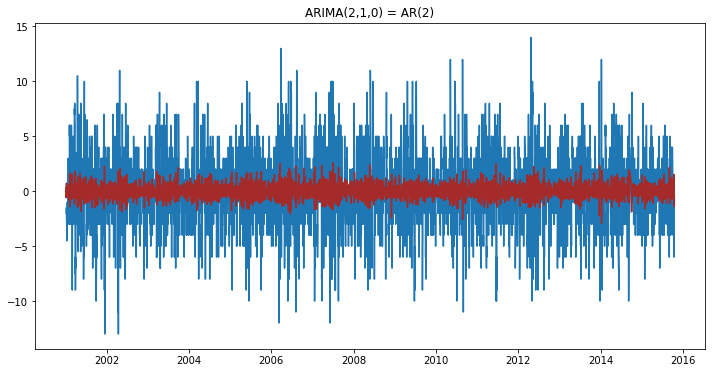

In [185]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_max, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_max_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())
AR='AR: 22822.841'

#### Paso3 (Modelo MA (Promedio Móvil))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmax(°C)   No. Observations:                 5381
Model:                 ARIMA(0, 1, 4)   Log Likelihood              -11194.235
Method:                       css-mle   S.D. of innovations              1.937
Date:                Fri, 19 Feb 2021   AIC                          22400.470
Time:                        23:53:27   BIC                          22440.014
Sample:                             1   HQIC                         22414.278
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013      0.006      0.205      0.837      -0.011       0.014
ma.L1.D.Tmax(°C)    -0.3555      0.014    -26.222      0.000      -0.382      -0.329
ma.L2.D.Tmax(°C)    -0.1841 

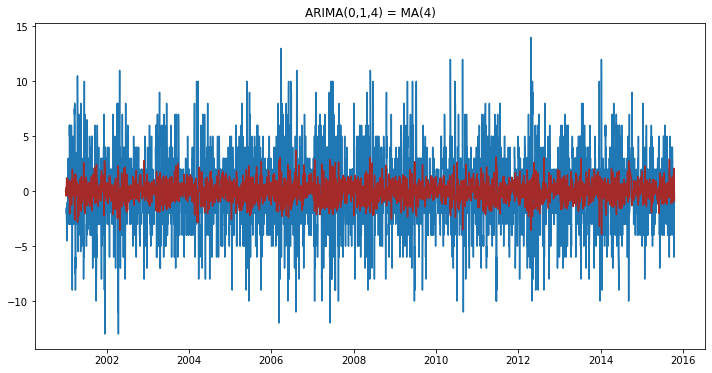

In [186]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_max, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_max_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())
MA='MA: 22400.470'

#### Paso4 (Modelo ARIMA (Auto-Regresión + Promedio Móvil))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmax(°C)   No. Observations:                 5381
Model:                 ARIMA(2, 1, 4)   Log Likelihood              -11185.957
Method:                       css-mle   S.D. of innovations              1.934
Date:                Fri, 19 Feb 2021   AIC                          22387.914
Time:                        23:53:31   BIC                          22440.639
Sample:                             1   HQIC                         22406.325
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0014      0.006      0.241      0.810      -0.010       0.013
ar.L1.D.Tmax(°C)     0.3895      0.719      0.542      0.588      -1.019       1.798
ar.L2.D.Tmax(°C)     0.0573 

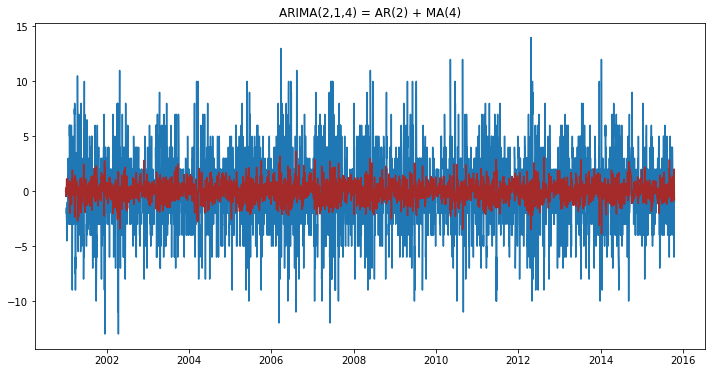

In [187]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_max, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_max_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())
ARIMA='ARIMA: 22387.914'
print(AR)
print(MA)
print(ARIMA)
print('ARIMA(2,1,4): AIC = 22387.914 <- Es el menor AIC')

#### Paso5 (Prediccion y RMSE)


In [188]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)
# Le sumamos las predicciones de ARIMA a la serie observada (ts_max)
predictions_ARIMA = pd.Series(ts_max, index = ts_max.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head(2))
print(predictions_ARIMA.tail(2))

Fecha
2001-01-02    0.001406
2001-01-03    0.224130
2001-01-04    0.292937
2001-01-05    0.087120
2001-01-06   -0.489780
                ...   
2015-10-12    1.950356
2015-10-13    2.018490
2015-10-14    0.440362
2015-10-15   -0.529348
2015-10-16   -0.760591
Length: 5381, dtype: float64
Fecha
2001-01-01          NaN
2001-01-02    28.001406
dtype: float64
Fecha
2015-10-15    36.470652
2015-10-16    35.239409
dtype: float64


##### Graficamos


 El error de la Raiz Cuadrada de la Media es:  0.8046669384287444


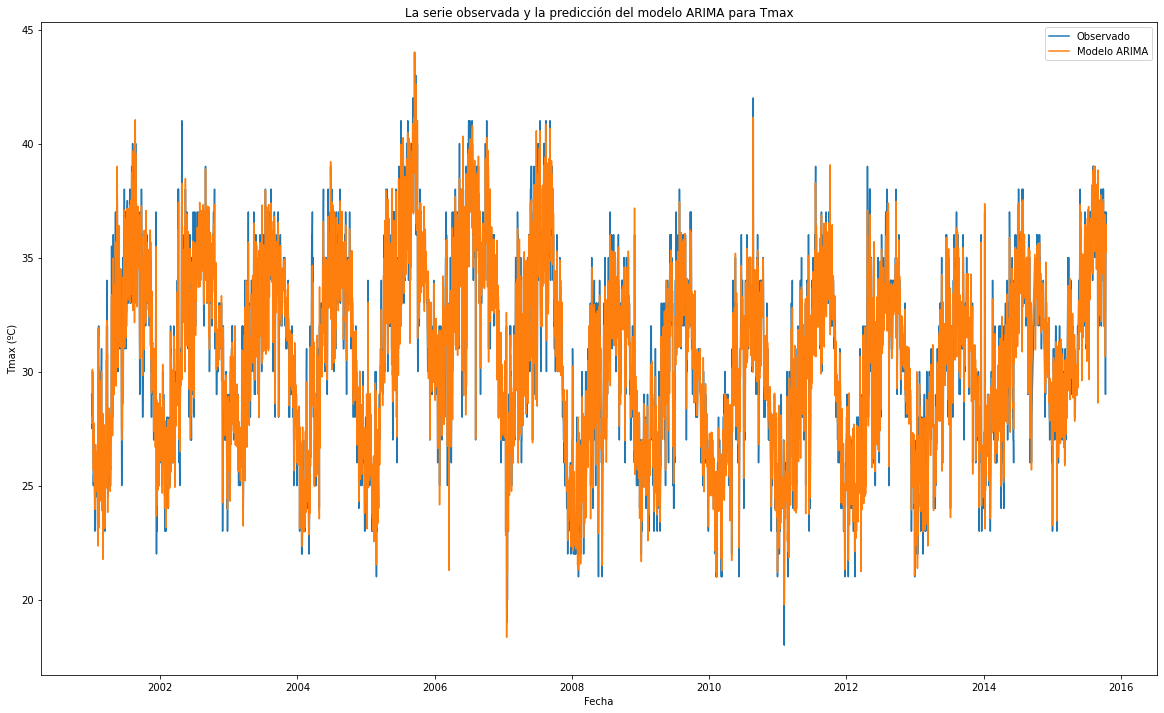

In [189]:
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (20,12)

plt.plot(ts_max, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_max)**2))
print('\033[1m','El error de la Raiz Cuadrada de la Media es:', '\033[0m', RMSE)

## Tmin

### Preparacion

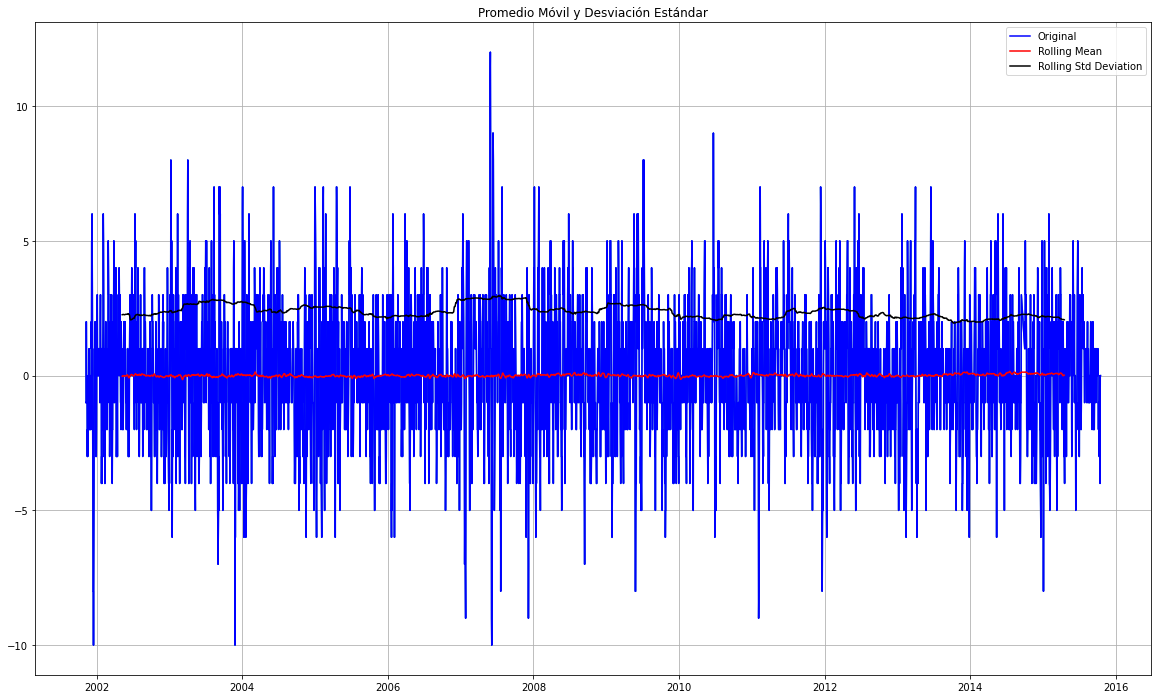

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.118109e+01
p-value                        2.499980e-20
#Lags Used                     2.800000e+01
Number of Observations Used    5.046000e+03
Critical Value (1%)           -3.431647e+00
Critical Value (5%)           -2.862113e+00
Critical Value (10%)          -2.567075e+00
dtype: float64


5075

In [190]:
# Diferenciamos usando la función df.shift()
ts_min_diff = ts_min - ts_min.shift(periods=7)
plt.plot(ts_min_diff);
# Diferenciamos usando la función df.shift()
# Probamos la estacionaridad
ts_min_diff.dropna(inplace=True)
test_stationarity(ts_min_diff)
len(ts_min_diff)

### Metodo ARIMA

#### Paso1

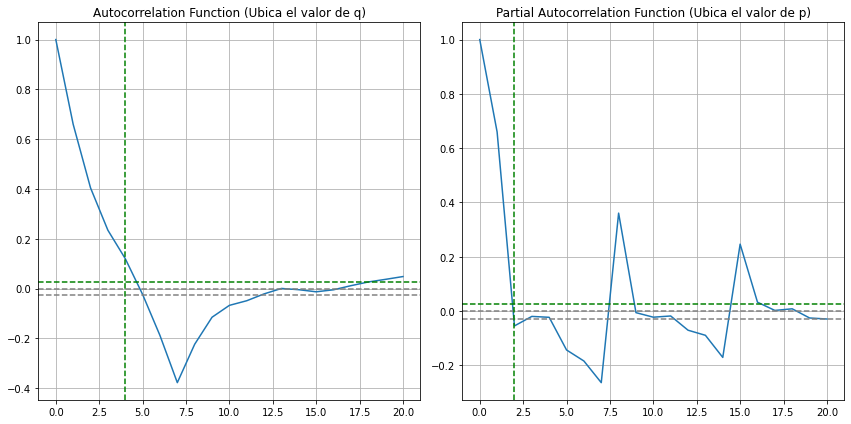

In [191]:
# Aplicamos ARIMA
lag_acf = acf(ts_min_diff, nlags=20)
lag_pacf = pacf(ts_min_diff, nlags=20, method = 'ols')

plt.rcParams["figure.figsize"] = (12,6) # Tamaño de las gráficas

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_min_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_min_diff)), linestyle='--', color='green')
# Líneas verticales como referencias
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_min_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_min_diff)), linestyle='--', color='green')

#Líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

#### Paso2 (Modelo AR (Auto-Regresión))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmin(°C)   No. Observations:                 5081
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -8716.908
Method:                       css-mle   S.D. of innovations              1.345
Date:                Fri, 19 Feb 2021   AIC                          17441.816
Time:                        23:53:54   BIC                          17467.949
Sample:                             1   HQIC                         17450.968
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0006      0.014      0.043      0.966      -0.028       0.029
ar.L1.D.Tmin(°C)    -0.1550      0.014    -11.188      0.000      -0.182      -0.128
ar.L2.D.Tmin(°C)    -0.1557 

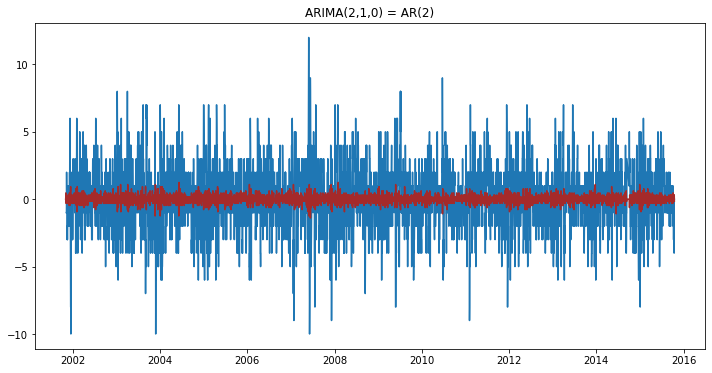

In [198]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_min, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_min_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())
AR='AR: 17441.816'

#### Paso3 (Modelo MA (Promedio Móvil))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmax(°C)   No. Observations:                 5381
Model:                 ARIMA(0, 1, 5)   Log Likelihood              -11188.162
Method:                       css-mle   S.D. of innovations              1.935
Date:                Fri, 19 Feb 2021   AIC                          22390.325
Time:                        23:53:59   BIC                          22436.459
Sample:                             1   HQIC                         22406.434
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0014      0.006      0.223      0.823      -0.011       0.013
ma.L1.D.Tmax(°C)    -0.3529      0.014    -25.928      0.000      -0.380      -0.326
ma.L2.D.Tmax(°C)    -0.1797 

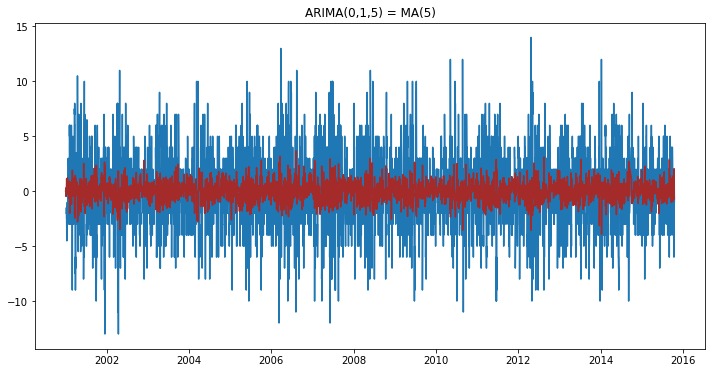

In [199]:
# Modelo MA(q): (p,d,q) = (0,1,5) 
model = ARIMA(ts_max, order=(0,1,5), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_max_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,5) = MA(5)')
print(results_MA.summary())
MA='MA: 22390.325'

#### Paso4 (Modelo ARIMA (Auto-Regresión + Promedio Móvil))


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.Tmax(°C)   No. Observations:                 5381
Model:                 ARIMA(2, 1, 5)   Log Likelihood              -11185.947
Method:                       css-mle   S.D. of innovations              1.934
Date:                Fri, 19 Feb 2021   AIC                          22389.894
Time:                        23:54:09   BIC                          22449.210
Sample:                             1   HQIC                         22410.606
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0014      0.006      0.242      0.809      -0.010       0.013
ar.L1.D.Tmax(°C)     1.0926      1.061      1.030      0.303      -0.987       3.172
ar.L2.D.Tmax(°C)    -0.2838 

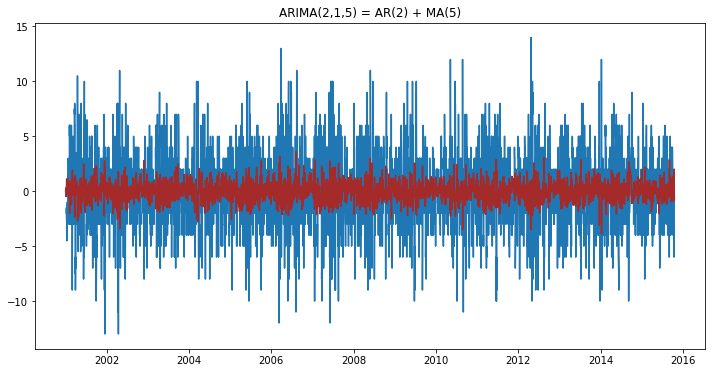

In [200]:
# Modelo ARIMA(p): (p,d,q) = (2,1,5) 
model = ARIMA(ts_max, order=(2,1,5), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_max_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,5) = AR(2) + MA(5)')
print(results_ARIMA.summary())
ARIMA='ARIMA: 22387.914'
print(AR)
print(MA)
print(ARIMA)
print('AR(2,1,0): AR = 17441.816 <- Es el menor AIC')

#### Paso5 (Prediccion y RMSE)


In [201]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
print(predictions_AR_diff)
# Le sumamos las predicciones de AR a la serie observada (ts_min)
predictions_AR = pd.Series(ts_min, index = ts_min.index)
predictions_AR = predictions_AR.add(predictions_AR_diff)
print(predictions_AR.head(2))
print(predictions_AR.tail(2))

Fecha
2001-11-02    0.000614
2001-11-03    0.134851
2001-11-04    0.466595
2001-11-05    0.157166
2001-11-06   -0.309942
                ...   
2015-10-12    0.155848
2015-10-13    0.311551
2015-10-14   -0.153581
2015-10-15    0.309574
2015-10-16   -0.151604
Length: 5081, dtype: float64
Fecha
2001-11-01          NaN
2001-11-02    21.000614
dtype: float64
Fecha
2015-10-15    26.309574
2015-10-16    24.848396
dtype: float64


Graficamos

 El error de la Raiz Cuadrada de la Media es:  0.8046669384287444


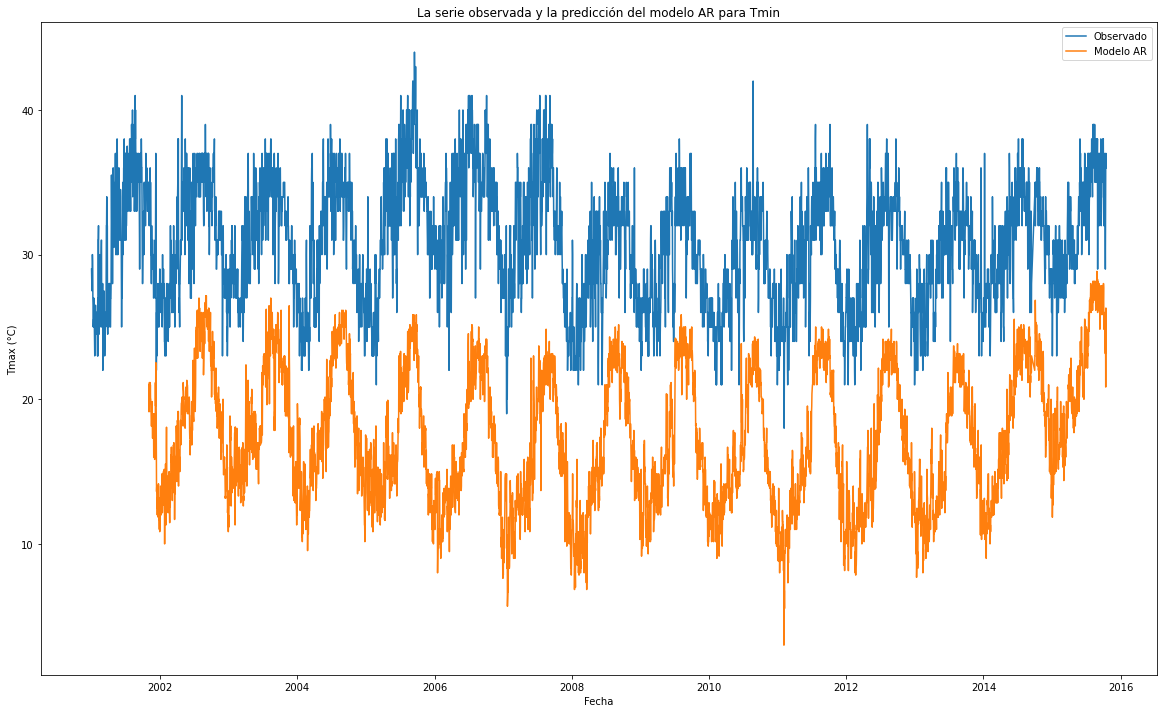

In [202]:
# Graficamos la serie original y las predicciones con AR
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (20,12)

plt.plot(ts_max, label='Observado');
plt.plot(predictions_AR, label='Modelo AR');
plt.xlabel('Fecha')
plt.ylabel('Tmax (°C)')
plt.title('La serie observada y la predicción del modelo AR para Tmin')
plt.legend(loc='best');

# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_max)**2))
print('\033[1m','El error de la Raiz Cuadrada de la Media es:', '\033[0m', RMSE)